# Predicting News Article Popularity 

## Business Understading 

Advertising on social media has empowered new and smaller media companies to publish textual content to a broader audience, which can then further spread their content. This presents the decision to make about which content to advertise or share in order to maximize the publisher’s reach. For even the smallest publishers, this decision can be supported with simple machine learning models analyzing content metadata. 

## Data Understading 

In order to show how social media popularity for textual media can be modeled, article metadata was gathered from the New York Time's API website. Although one of the largest publishers of news articles, the data is of very high quality and should resemble what other companies have access to in-house. 

Two APIs were used. First, the __[NYT Archive API](https://developer.nytimes.com/docs/archive-product/1/overview)__,  which returns every article for a given range of months and years. Second, the __[NYT Most Popular API](https://developer.nytimes.com/docs/most-popular-product/1/overview)__, which returns the most popular articles on NYTimes.com based on emails, Facebook shares, or views on the NYT site. For this project Facebook shares was chosen and calls were made to the API once per day to gather that day's top 20 list. Articles in the archive that were listed on a top 20 list were then labeled as a popular article for a modeling target. 

#### Importing the required packages

In [56]:
# file manipulation 
import os

# data manipulation 
import re
import datetime as dt
import pandas as pd
import numpy as np
import math
from functions import *

# modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve

# sampling
from imblearn.over_sampling import SMOTE

# preprocessing text
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 


# plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#### Loading the data
The scripts to request, clean and store both the article archive data and the daily top 20 most shared on Facebook lists can be found in [request_archive.py](./request_archive.py) and [request_most_shared_articles.py](./request_most_shared_articles.py). One request for a top 20 list for the previous 30 days was made to help label some articles in the archive as popular that were published before daily collection of a top 20 list was begun. 

The archive data contains all articles from December and all from January up to the end of the training phase on January 15th. Any row with a Null values in the archive were dropped and the date published column was changed to the datetime data type. The metadate that was collected for modeling was the headline of the article, keywords for the article, a snippet from the article and the word count for the article. Additionaly the URI and date published was grabbed for each article. 

For each top 20 list the URI, date published and date the list was sourced was taken. 

In [57]:
# load archive articles from csv in data directory
df = pd.read_csv('data/archive_train.csv')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())
df.dropna(inplace=True)

# load seperate top 20 lists in folder in data directory into single dataframe 
df_most_shared = load_most_shared('data/most_popular_train')

<br>
A list was made to house the URI's, the unique index for each article, for articles appearing on a top 20 list at least once. Then a popular column was created for the archive dataframe by iterating over the list of the highly shared articles and assigning a 0 if that articles URI was not present on the list and 1 for if it was. This is the target column for a models.

In [58]:
# create list, then interate over it to make target column
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df['uri']]

In [59]:
# view the dataframe
df.head()

,uri,date_published,headline,keywords,snippet,word_count,popular
0,nyt://article/4e2abcbc-9563-56c0-bf18-c93ce4e7...,2021-12-01,let’s end the covid blame games,coronavirus omicron variantcoronavirus (2019-n...,"Finger pointing is pointless, divisive and dumb.",918,0
1,nyt://article/f7a5e7ef-e4cd-575c-a0e1-ff4d18d5...,2021-12-01,trump’s iran policy has become a disaster for ...,irannuclear weaponsembargoes and sanctionsunit...,Withdrawing from the Iran nuclear deal was a m...,1560,0
2,nyt://article/778af86c-b600-5aeb-be98-0a9a1aa1...,2021-12-01,this extinct eagle may have gulped guts like a...,eagles (birds)vultures (birds)condorsendangere...,Scientists suggest the largest eagle that ever...,913,0
3,nyt://article/fb7763c2-0f41-5c81-9ecf-17607ba5...,2021-12-01,republican recriminations point to a rocky pat...,republican partyhouse of representativesboeber...,Simmering tensions between the far-right flank...,1172,0
4,nyt://article/ba0afd37-0c00-5535-8868-21130e28...,2021-12-01,a times editor who attended oxford recalls a d...,school shootings and armed attacks,Three teenage students were killed on Tuesday ...,309,0


## Exploratory Data Analysis  
Checking `df.info()` shows that both dataframes individually have equal values with no Null values to take care of. It also shows that the datatypes are what we expect and want. 

In [60]:
print(df.info())
print()
print(df_most_shared.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 0 to 5723
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             5149 non-null   object
 1   date_published  5149 non-null   object
 2   headline        5149 non-null   object
 3   keywords        5149 non-null   object
 4   snippet         5149 non-null   object
 5   word_count      5149 non-null   int64 
 6   popular         5149 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 321.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 2022-01-13 to 2022-01-10
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             180 non-null    object
 1   date_published  180 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB
None


##### Archive articles
Looking at the distribution of article popularity reveals massive class imbalance. Only 2% of the articles in the archive appear on a top 20 list. This is particularly because of the articles included in the archive that were published in December and January before daily top 20 lists were started to be collected. Due to the API's constraints, only the daily top 20 list from the day the request was made are available. 

,sum,percentage
popular,,
0,5024,0.98
1,125,0.02


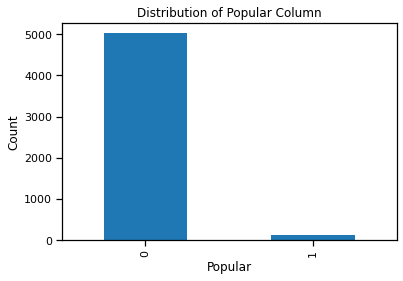

In [61]:
# function makes a dataframe to display target variable value's sum and percentage
# also, it plots the target variable's value distribution
target_distribution = summerize_value_counts(df.popular)
target_distribution

##### Top 20 most shared articles
Looking at each day's top 20 list and the distribution of dates when the articles were published originally shows that the majority of the articles on each list were published in the two days before the day of the list's creation, with a smaller proportion having been published three days before or on the day of creation. 

functions used to load, clean and plot the date are found in [functions.py](./functions.py).

In [62]:
# load csv's into a list of dataframes 
df_list_load = load_most_shared_eda('data/most_popular_train')

# change date columns to datetime dtype and sort list by date of top 20 list in ascending order 
df_list = clean_most_shared_eda(df_list_load)

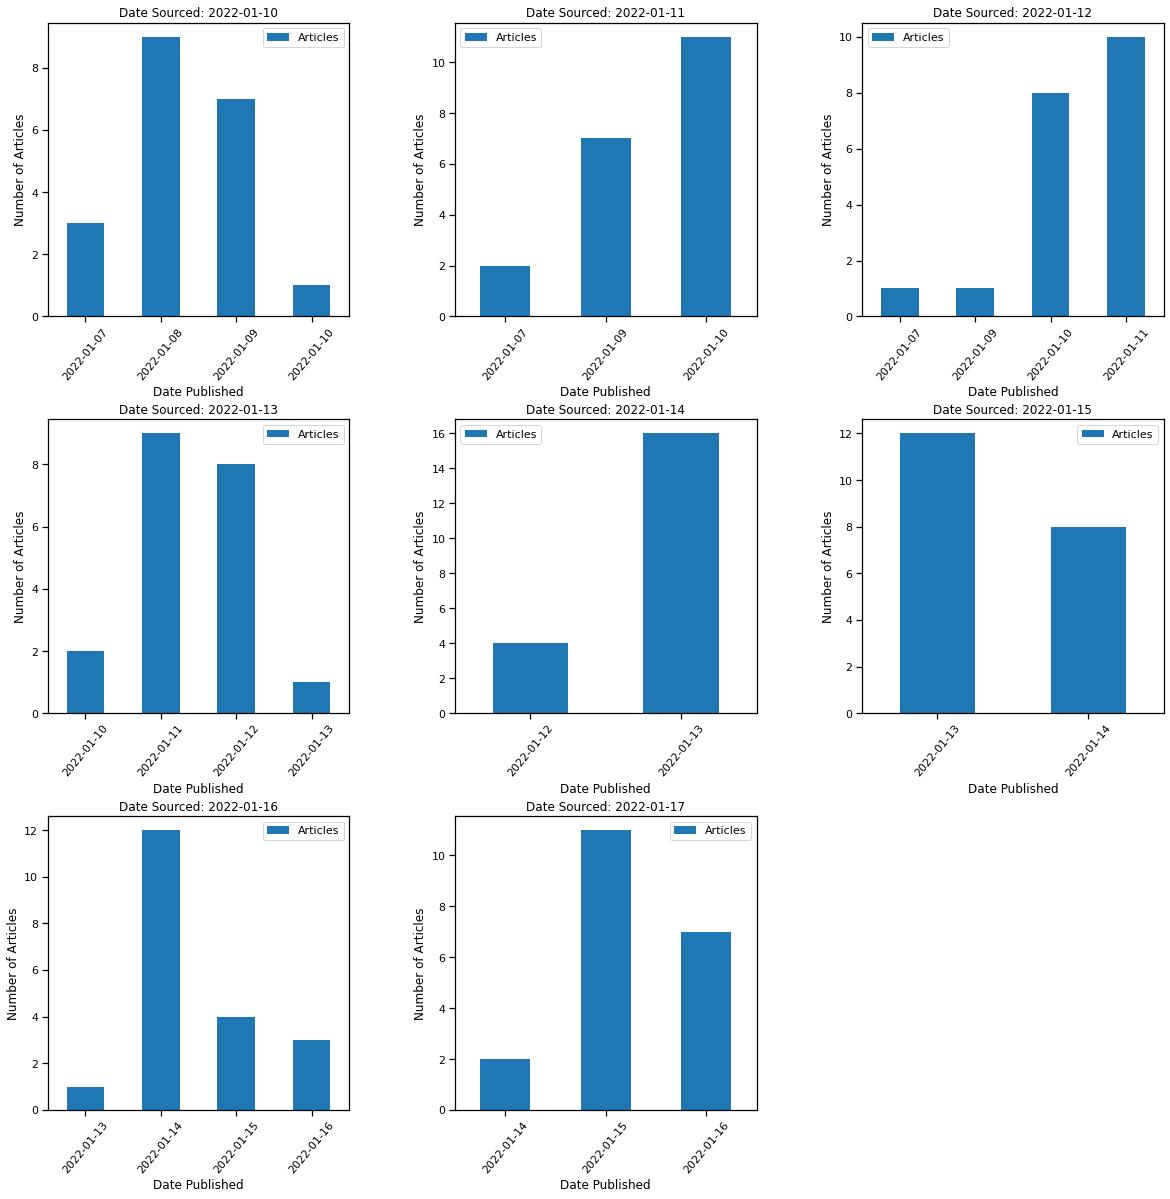

In [63]:
# generate correct amount of subplots based on length of list then plot each dataframe in list
plot_most_shared(df_list)

## Data Preperation

##### Train-Test Split
Features are separated from the target and a test size of 40% is selected. This is because the final model is trained with the testing data results of the models before it. To ensure it has enough training data, a relatively high test size proportion was chosen. 

Also, the random state is established as 0, which will be the sate for all models going forward. 

In [64]:
# features = X, target = y
X = df.drop('popular', axis=1)
y = df.popular

In [65]:
# random state of 0 is established for the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.40)

## Dummy classifier
A baseline model is established with the data.

In [66]:
# initialize baseline model
dummy = DummyClassifier(random_state=0, strategy='stratified') 

# fit with training data and predict with test set
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [67]:
# baseline model accuracy 
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9495145631067962


In [68]:
# count how many articles are labeled popular by predicitng probabilities
dummy_prob = dummy.predict_proba(X_test)
dummy_predict_popular = [x[1] for x in dummy_prob if x[1] == 1]
len(dummy_predict_popular)

65

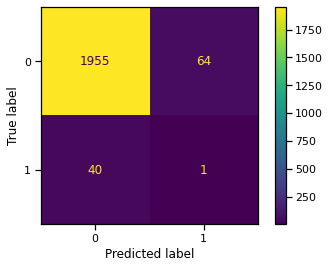

In [69]:
# plot confusion matrix to show error of the model
# 0: 'not popular', 1: 'popular'
plot_confusion_matrix(dummy, X_test, y_test);

The baseline model achived a 96% accuracy rate, but this is due to the massive class imbalence towards articles that are not featured on the most shared list. The bottom right box in the confusion matrix shows that the baseline model correctly predicted  0 of the articles that were on a top 20 list. 

## Data Preprocessing 

### Headline

##### TfidfVectorizer

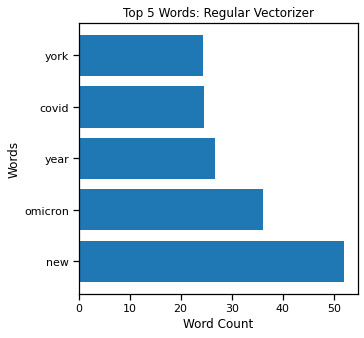

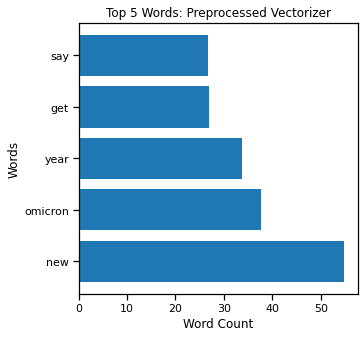

In [70]:
# regular vectorizer
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tf, y_train,
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tf
# data : X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf



# tokenize and lemmatize before vectorization
headline_tok_tf, X_train_headline_tok_tf, X_test_headline_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm = smote_data(X_train_headline_tok_tf, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_tf
# data : X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm, X_test_headline_tok_tf

plot_top_words(headline_tf, X_train_headline_tf, 'Regular Vectorizer');
plot_top_words(headline_tok_tf, X_train_headline_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

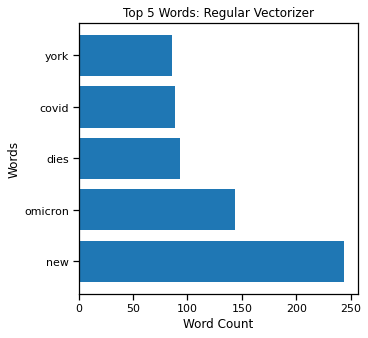

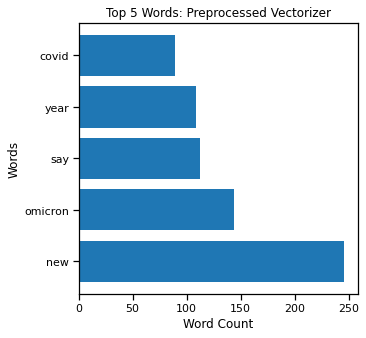

In [71]:
# regular vectorizer
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_cv
# data: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv



# tokenize and lemmatize before vectorization
headline_tok_cv, X_train_headline_tok_cv, X_test_headline_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm = smote_data(X_train_headline_tok_cv, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_cv
# data: X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm, X_test_headline_tok_cv

plot_top_words(headline_cv, X_train_headline_cv, 'Regular Vectorizer');
plot_top_words(headline_tok_cv, X_train_headline_tok_cv, 'Preprocessed Vectorizer');

### Keywords

##### TfidfVectorizer

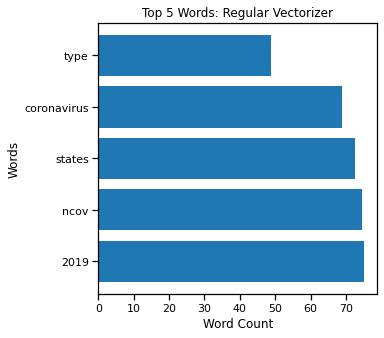

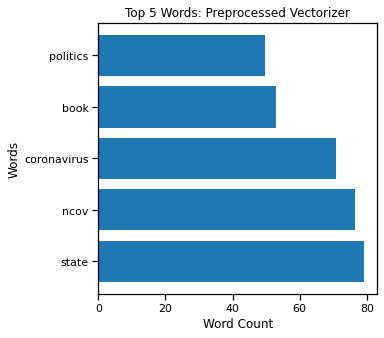

In [72]:
# regular vectorizer
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tf, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tf
# data: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf



# tokenize and lemmatize before vectorization
keywords_tok_tf, X_train_keywords_tok_tf, X_test_keywords_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm = smote_data(X_train_keywords_tok_tf, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_tf
# data: X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm, X_test_keywords_tok_tf

plot_top_words(keywords_tf, X_train_keywords_tf, 'Regular Vectorizer');
plot_top_words(keywords_tok_tf, X_train_keywords_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

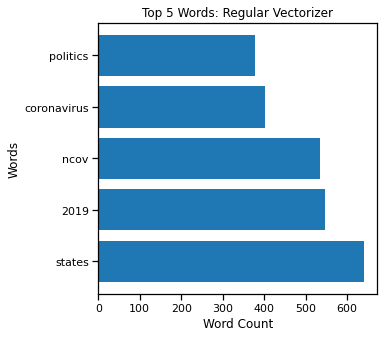

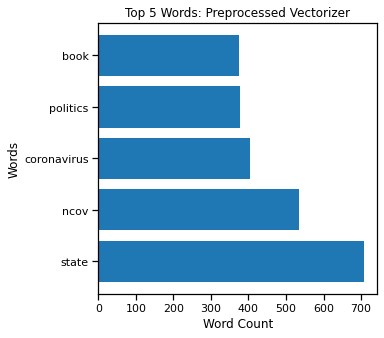

In [73]:
# regular vectorizer
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_cv
# data: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv



# tokenize and lemmatize before vectorization
keywords_tok_cv, X_train_keywords_tok_cv, X_test_keywords_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm = smote_data(X_train_keywords_tok_cv, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_cv
# data: X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm, X_test_keywords_tok_cv

plot_top_words(keywords_cv, X_train_keywords_cv, 'Regular Vectorizer');
plot_top_words(keywords_tok_cv, X_train_keywords_tok_cv, 'Preprocessed Vectorizer');

### Snippet

##### TfidfVectorizer

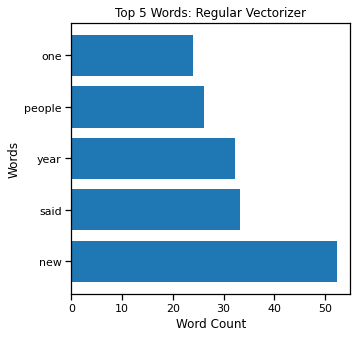

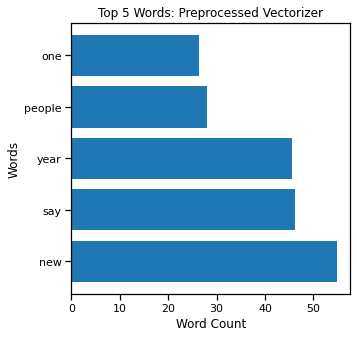

In [74]:
# regular vectorizer
snippet_tf, X_train_snippet_tf, X_test_snippet_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.snippet, X_test.snippet)
# smote vectorized training data
X_train_snippet_tf_sm, y_train_snippet_tf_sm = smote_data(X_train_snippet_tf, y_train, 
                                                          sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tf
# data: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf



# tokenize and lemmatize before vectorization
snippet_tok_tf, X_train_snippet_tok_tf, X_test_snippet_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                X_train.snippet, 
                                                                                X_test.snippet)
# smote preprocessed vectorized training data
X_train_snippet_tok_tf_sm, y_train_snippet_tok_tf_sm = smote_data(X_train_snippet_tok_tf, y_train, 
                                                                  sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tok_tf
# data: X_train_snippet_tok_tf_sm, y_train_snippet_tok_tf_sm, X_test_snippet_tok_tf

plot_top_words(snippet_tf, X_train_snippet_tf, 'Regular Vectorizer');
plot_top_words(snippet_tok_tf, X_train_snippet_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

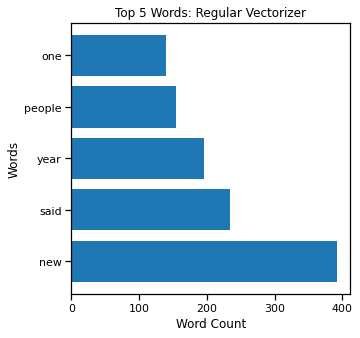

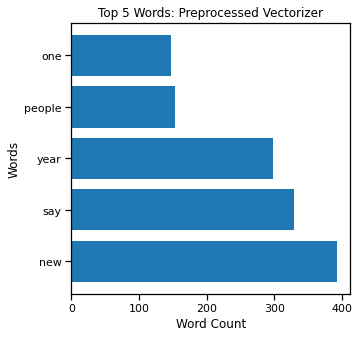

In [75]:
# regular vectorizer
snippet_cv, X_train_snippet_cv, X_test_snippet_cv = vectorize_feature(CountVectorizer,
                                                                      X_train.snippet, X_test.snippet)
# smote vectorized training data
X_train_snippet_cv_sm, y_train_snippet_cv_sm = smote_data(X_train_snippet_cv, y_train, 
                                                          sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_cv
# data: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv



# tokenize and lemmatize before vectorization
snippet_tok_cv, X_train_snippet_tok_cv, X_test_snippet_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                X_train.snippet, 
                                                                                X_test.snippet)
# smote preprocessed vectorized training data
X_train_snippet_tok_cv_sm, y_train_snippet_tok_cv_sm = smote_data(X_train_snippet_tok_cv, y_train, 
                                                                  sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_tok_cv
# data: X_train_snippet_tok_cv_sm, y_train_snippet_tok_cv_sm, X_test_snippet_tok_cv

# plot 
plot_top_words(snippet_cv, X_train_snippet_cv, 'Regular Vectorizer');
plot_top_words(snippet_tok_cv, X_train_snippet_tok_cv, 'Preprocessed Vectorizer');

### Word Count

In [76]:
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), 
                                                          y_train, sampling_strategy='auto',
                                                          random_state=0)

## Model Training - Text

In [77]:
# function to run a random forrest 
# returns the model and list of proabilities 
def random_forrest_proba(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50,75,100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted probabilities that article is a popular article in a list 
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # print model accuracy 
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # plot an ROC curve 
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, target_probability

In [78]:
# function to run a random forrest 
# returns the model and a list of class labels 
def random_forrest_class(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50,75,100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = gs.predict(X_test)
    
    # print model accuracy
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, class_prediction

### Headline

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9796116504854369
number of probabilities: 2060



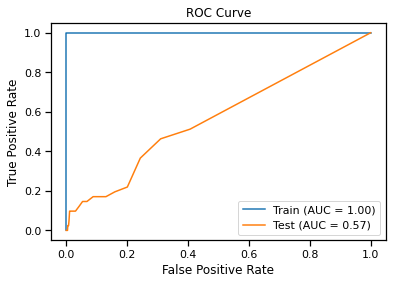

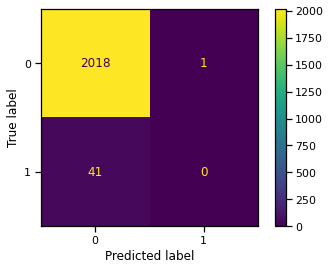

In [79]:
headline_proba_rf, headline_proba = random_forrest_proba(X_train_headline_tf_sm, y_train_headline_tf_sm, 
                                                         X_test_headline_tf, y_test)

print(f'number of probabilities: {len(headline_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.9791262135922331
number of probabilities: 2060



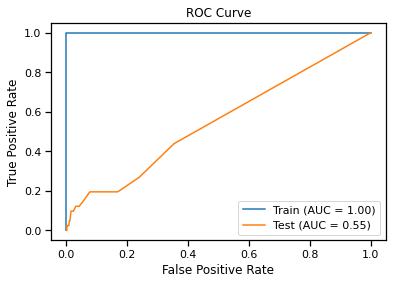

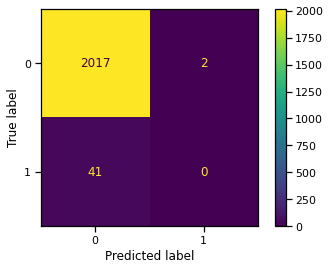

In [80]:
headline_proba_rf_tok, headline_proba_tok = random_forrest_proba(X_train_headline_tok_tf_sm, 
                                                                 y_train_headline_tok_tf_sm,
                                                                 X_test_headline_tok_tf, y_test)

print(f'number of probabilities: {len(headline_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.8116504854368932
number of class predictions: 2060



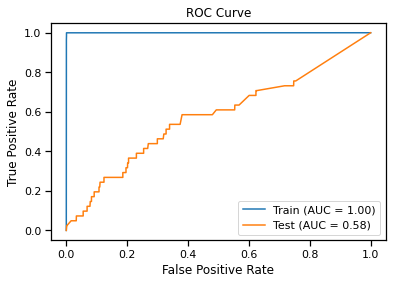

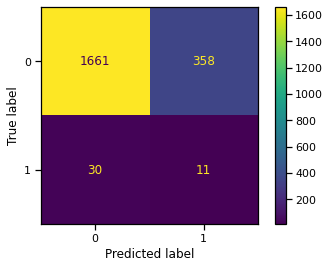

In [81]:
headline_class_rf, headline_class = random_forrest_class(X_train_headline_cv_sm, y_train_headline_cv_sm, 
                                                         X_test_headline_cv, y_test)

print(f'number of class predictions: {len(headline_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.7257281553398058
number of class predictions: 2060



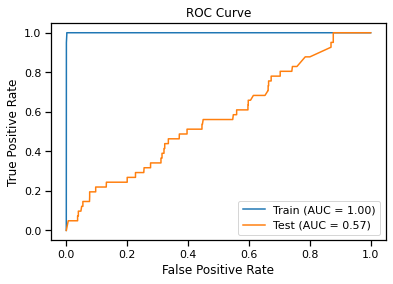

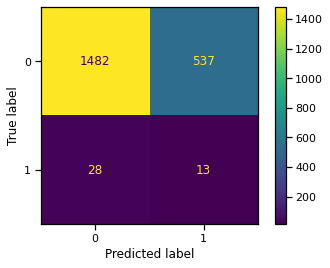

In [82]:
headline_class_rf_tok, headline_class_tok = random_forrest_class(X_train_headline_tok_cv_sm, 
                                                                 y_train_headline_tok_cv_sm,
                                                                 X_test_headline_tok_cv, y_test)

print(f'number of class predictions: {len(headline_class_tok)}')
print()

### Keywords

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9800970873786408
number of probabilities: 2060



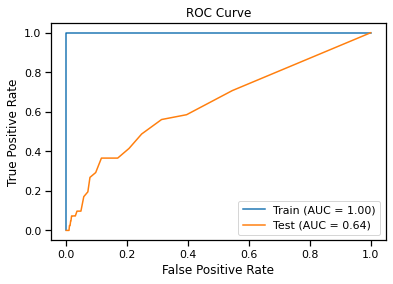

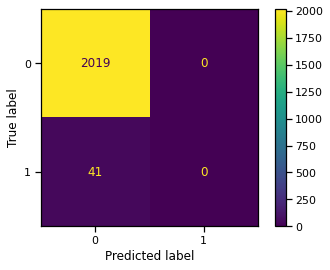

In [83]:
keywords_proba_rf, keywords_proba = random_forrest_proba(X_train_keywords_tf_sm, y_train_keywords_tf_sm, 
                                                         X_test_keywords_tf, y_test)

print(f'number of probabilities: {len(keywords_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.9800970873786408
number of probabilities: 2060



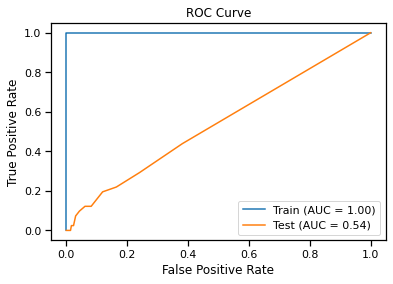

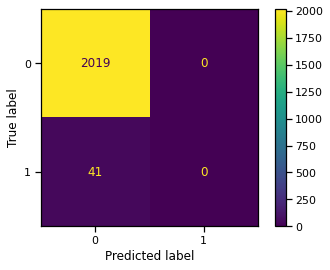

In [84]:
keywords_proba_rf_tok, keywords_proba_tok = random_forrest_proba(X_train_keywords_tok_tf_sm, 
                                                                 y_train_keywords_tok_tf_sm, 
                                                                 X_test_keywords_tok_tf, y_test)

print(f'number of probabilities: {len(keywords_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.8203883495145631
number of class predictions: 2060



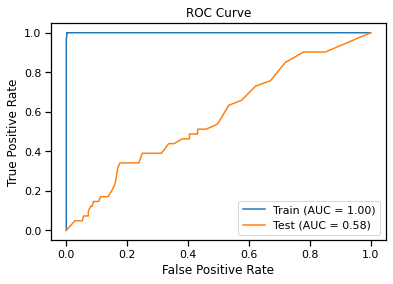

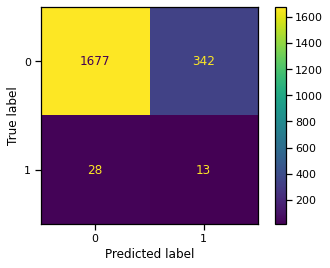

In [85]:
keywords_class_rf, keywords_class = random_forrest_class(X_train_keywords_cv_sm, y_train_keywords_cv_sm, 
                                                         X_test_keywords_cv, y_test)

print(f'number of class predictions: {len(keywords_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.7616504854368932
number of class predictions: 2060



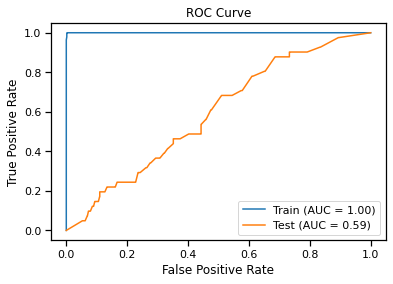

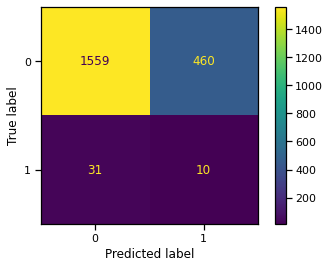

In [86]:
keywords_class_rf_tok, keywords_class_tok = random_forrest_class(X_train_keywords_tok_cv_sm, 
                                                                 y_train_keywords_tok_cv_sm, 
                                                                 X_test_keywords_tok_cv, y_test)

print(f'number of class predictions: {len(keywords_class_tok)}')
print()

### Snippet 

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9800970873786408
number of probabilities: 2060



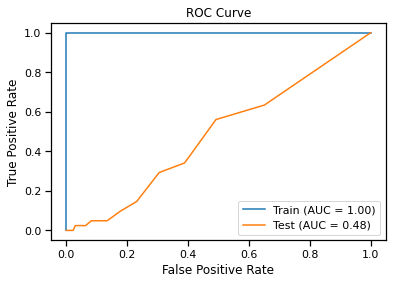

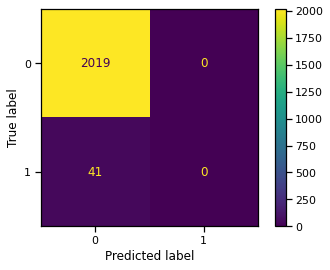

In [87]:
snippet_proba_rf, snippet_proba = random_forrest_proba(X_train_snippet_tf_sm, y_train_snippet_tf_sm, 
                                                       X_test_snippet_tf, y_test)

print(f'number of probabilities: {len(snippet_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.9800970873786408
number of probabilities: 2060



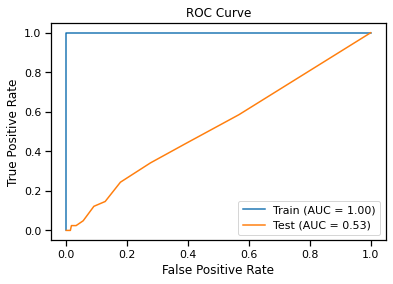

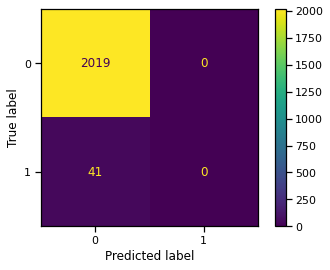

In [88]:
snippet_proba_rf_tok, snippet_proba_tok = random_forrest_proba(X_train_snippet_tok_tf_sm, 
                                                               y_train_snippet_tok_tf_sm,
                                                               X_test_snippet_tok_tf, y_test)

print(f'number of probabilities: {len(snippet_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.8830097087378641
number of class predictions: 2060



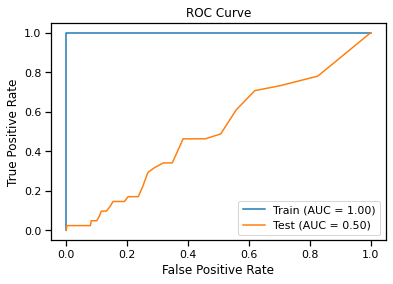

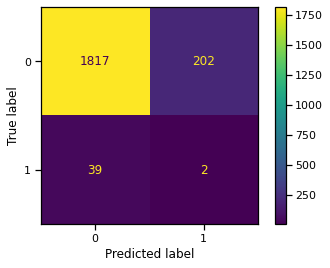

In [89]:
snippet_class_rf, snippet_class = random_forrest_class(X_train_snippet_cv_sm, y_train_snippet_cv_sm, 
                                                       X_test_snippet_cv, y_test)

print(f'number of class predictions: {len(snippet_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.8330097087378641
number of class predictions: 2060



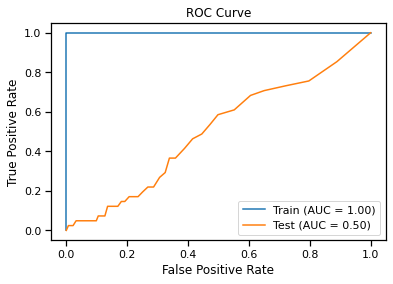

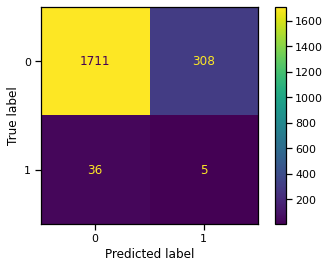

In [90]:
snippet_class_rf_tok, snippet_class_tok = random_forrest_class(X_train_snippet_tok_cv_sm, 
                                                               y_train_snippet_tok_cv_sm,
                                                               X_test_snippet_tok_cv, y_test)

print(f'number of class predictions: {len(snippet_class_tok)}')
print()

## Model Training - Numeric

### Word Count

In [94]:
# function to run a logistic regression 
# returns the model, a list of proabilities, and a list of class labels 
def log_regression_word_count(X_train, y_train, X_test, y_test):
    
    # initiate logsitic regression and fit with training data 
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = clf.predict(X_test.values.reshape(-1, 1))
    
    # store predicted probabilities that article is a popular article in a list
    probabilities = clf.predict_proba(X_test.values.reshape(-1, 1))
    probabilities = [x[1] for x in probabilities]
    
    # print model accuracy
    score = clf.score(X_test.values.reshape(-1, 1), y_test)
    print(f'mean accuracy: {score}')
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(clf, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(clf, X_test.values.reshape(-1, 1), y_test, name='Test', ax=ax);
    
    # plot confusion matrix
    plot_confusion_matrix(clf, X_test.values.reshape(-1, 1), y_test)
    
    return clf, probabilities, class_prediction

mean accuracy: 0.5485436893203883
number of probabilities: 2060
number of class predictions: 2060



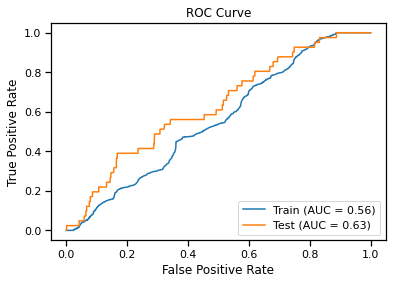

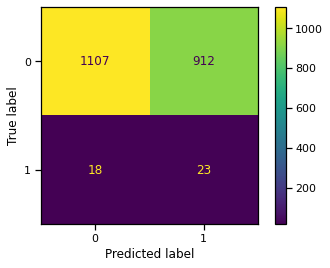

In [95]:
word_count_log_reg, word_count_proba, word_count_class = log_regression_word_count(X_train_word_count_sm, 
                                                                                   y_train_word_count_sm, 
                                                                                   X_test.word_count, y_test)

print(f'number of probabilities: {len(word_count_proba)}')
print(f'number of class predictions: {len(word_count_class)}')
print()

## Cumulative Model 

In [91]:
# headline tfidf winners: headline_tf, headline_proba_rf, headline_proba
# headline cv winners: headline_cv, headline_class_rf, headline_class

In [92]:
# keywords tfidf winners: keywords_tf, keywords_proba_rf, keywords_proba
# keywords cv winners: keywords_cv, keywords_class_rf, keywords_class

In [96]:
# snippet tfidf winners: snippet_tok_tf, snippet_proba_rf_tok, snippet_proba_tok
# snippet cv winners: snippet_tok_cv, snippet_class_rf_tok, snippet_class_tok

### Cleaning 

##### Proability Data

In [97]:
df_predict_proba = pd.DataFrame({'headline_prob': headline_proba, 
                                 'keywords_prob': keywords_proba, 
                                 'snippet_prob': snippet_proba_tok, 
                                 'word_count_prob': word_count_proba})

In [98]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,0.000000,0.00,0.000000,0.520067
1,0.000000,0.00,0.000000,0.490251
2,0.146667,0.05,0.040000,0.504302
3,0.066667,0.02,0.146667,0.461076
4,0.000000,0.00,0.000000,0.493429


In [99]:
scaler = StandardScaler()

In [100]:
df_predict_proba.iloc[:,:] = scaler.fit_transform(df_predict_proba.iloc[:,:].to_numpy())

In [101]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,-0.521152,-0.576261,-0.736522,0.841658
1,-0.521152,-0.576261,-0.736522,-0.320010
2,2.321041,0.434379,0.496001,0.227440
3,0.770754,-0.172005,3.782729,-1.456741
4,-0.521152,-0.576261,-0.736522,-0.196221


In [102]:
df_predict_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   headline_prob    2060 non-null   float64
 1   keywords_prob    2060 non-null   float64
 2   snippet_prob     2060 non-null   float64
 3   word_count_prob  2060 non-null   float64
dtypes: float64(4)
memory usage: 64.5 KB


<br>

##### Class Labeled Data 

In [103]:
df_predict_class = pd.DataFrame({'headline_prob': headline_class, 
                                 'keywords_prob': keywords_class, 
                                 'snippet_prob': snippet_class_tok, 
                                 'word_count_class': word_count_class})

In [104]:
df_predict_class.head()

,headline_prob,keywords_prob,snippet_prob,word_count_class
0,0,0,1,1
1,0,0,0,0
2,1,0,0,1
3,0,1,0,0
4,0,0,0,0


In [105]:
df_predict_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   headline_prob     2060 non-null   int64
 1   keywords_prob     2060 non-null   int64
 2   snippet_prob      2060 non-null   int64
 3   word_count_class  2060 non-null   int64
dtypes: int64(4)
memory usage: 64.5 KB


<br>

### Training model

,sum,percentage
popular,,
0,2019,0.98
1,41,0.02


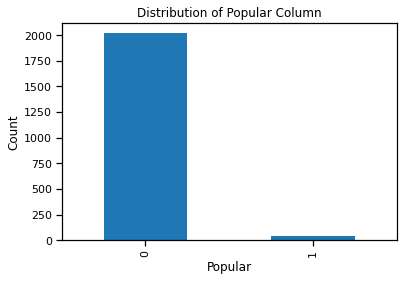

In [106]:
target_distribution_deploy = summerize_value_counts(y_test)
target_distribution_deploy



##### Predicting with Probabilities 

In [107]:
clf_proba = LogisticRegression()

In [108]:
clf_proba.fit(df_predict_proba, y_test)

LogisticRegression()

<br>

##### Predicitng with class labels

In [109]:
clf_class = LogisticRegression()

In [110]:
clf_class.fit(df_predict_class, y_test)

LogisticRegression()

## Model Deployment

In [55]:
# df_archive_deploy = pd.read_csv('data/archive_deploy.csv')
# df_archive_deploy.date_published = df_archive_deploy.date_published.apply(lambda x: pd.to_datetime(x).date())

# df_most_shared_deploy = load_most_shared('data/most_popular_deploy')

In [56]:
prediction_day = 'string_date'

In [57]:
def filter_predction_dfs(df_archive, df_shared, day_of_predict, delta=3):
    
    day_of_predict = pd.to_datetime(day_of_predict).date()
    time_delta = dt.timedelta(days=delta)
    cutoff_day = day_of_predict - time_delta
    
    df_deploy = df_archive[(df_archive.date_published >= cutoff_day) & 
                             (df_archive.date_published <= day_of_predict)]
    
    article_ids = df_deploy['uri']
    df_feature_deploy = df_deploy[['headline','keywords','snippet','word_count']]
    
    df_top_20 = df_shared[df_shared.date_sourced == day_of_predict]
    
    return article_ids, df_feature_deploy, df_top_20

In [58]:
# deployed_article_ids, df_feature_deploy, df_top_20 = filter_predction_dfs(prediction_day, delta=3, 
#                                                                   df_archive_deploy, df_most_shared_deploy)

In [59]:
def predict_with_probabilities():
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_tf_vec.transform()
    headline_tf_vec_tok.transform()
    headline_proba_rf.predict_proba()
    
    keywords_tf_vec.transform
    keywords_tf_vec_tok.transform
    keywords_proba_rf.predict_proba
    
    snippet_tf_vec.transform
    snippet_tf_vec_tok.transform
    snippet_proba_rf.predict_proba
    
    word_count_log_reg.predict_proba

    

In [60]:
def predict_with_class_labels(df):
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_cv_vec.transform
    headline_cv_vec_tok.transform
    headline_class_rf.predict
    
    keywords_cv_vec.transform
    keywords_cv_vec_tok.transform
    keywords_class_rf.predict
    
    snippet_cv_vec.transform
    snippet_cv_vec_tok.transform
    snippet_class_rf.predict
    
    word_count_log_reg.predict
    
    

In [61]:
headline_proba_pipe = Pipeline([('headline_tok_tf', headline_tok_tf), 
                                ('headline_proba_rf',headline_proba_rf)])

In [62]:
keywords_proba_pipe = Pipeline([('keywords_tok_tf', keywords_tok_tf), 
                                ('keywords_proba_rf', keywords_proba_rf)])

In [63]:
snippet_proba_pipe = Pipeline([('snippet_tok_tf', snippet_tok_tf), 
                               ('snippet_proba_rf', snippet_proba_rf)])

In [64]:
def proba_nlp_pipeline(features):
    
    headline_probs = headline_proba_pipe.predict_proba(features.headline)
    keywords_probs = keywords_proba_pipe.predict_proba(features.keywords)
    snippet_probs  = snippet_proba_pipe.predict_proba(features.snippet)
    word_count_probs = word_count_log_reg.predict_proba(features.word_count)
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs,
                       'snippet_probabilty': snippet_probs,
                       'word_count_probabilty': word_count_probs})
    
    scaler = StandardScaler()
    df.iloc[:,:] = scaler.fit_transform(df.iloc[:,:].to_numpy())
    
    return df

In [65]:
headline_class_pipe = Pipeline([('headline_tok_cv', headline_tok_cv), 
                                ('headline_class_rf', headline_class_rf)])

In [66]:
keywords_class_pipe = Pipeline([('keywords_tok_cv', keywords_tok_cv), 
                                ('keywords_class_rf', keywords_class_rf)])

In [67]:
snippet_class_pipe = Pipeline([('snippet_tok_cv', snippet_tok_cv), 
                               ('snippet_class_rf', snippet_class_rf)])

In [68]:
def class_nlp_pipeline(features):
    
    headline_probs = headline_class_pipe.predict(features.headline)
    keywords_probs = keywords_class_pipe.predict(features.keywords)
    snippet_probs  = snippet_class_pipe.predict(features.snippet)
    word_count_probs = word_count_log_reg.predict(features.word_count)
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs, 
                       'snippet_probabilty': snippet_probs, 
                       'word_count_probabilty': word_count_probs})
    return df

In [69]:
# proba_for_pred = proba_nlp_pipeline(df_feature_deploy)

In [70]:
# class_for_pred = class_nlp_pipeline(df_feature_deploy)

In [71]:
# predictions_from_proba = clf_proba.predict_proba(proba_for_pred)

In [72]:
# predictions_from_class = clf_class.predict_proba(class_for_pred)

In [74]:
top_20_from_proba = pd.DataFrame([deployed_article_ids, pd.Series(predictions_from_proba, 
                                                                  index=deployed_article_ids.index, 
                                                                  name='predictions_from_proba')]).T

# top_20_from_proba.sort_values(top_20_from_proba.iloc[:, -1:], ascending=False)

In [ ]:
top_20_from_class = pd.DataFrame([deployed_article_ids, pd.Series(predictions_from_class, 
                                                                  index=deployed_article_ids.index, 
                                                                  name='predictions_from_class')]).T

# top_20_from_class.sort_values(top_20_from_class.iloc[:, -1:], ascending=False)

In [ ]:
def save_predictions(prediction_day, proba_top_20, class_top_20):
    
    proba_top_20.to_csv(f'proba_top_20_{prediction_day}.csv')
    class_top_20.to_csv(f'proba_top_20_{prediction_day}.csv')

In [ ]:
def test_predictions(prediction_day):
    
    
    
    

In [ ]:
test_idx = pd.Index([23,46,78])

In [ ]:
col1 = pd.Series([1,2,3], index=test_idx)
col2 = [4,5,6]

In [ ]:
col1

In [ ]:
test_df = pd.DataFrame([col1, pd.Series(col2, index=col1.index)]).T.sort_values(1, ascending=False)
test_df

In [ ]:
test_df.iloc[:, -1:]